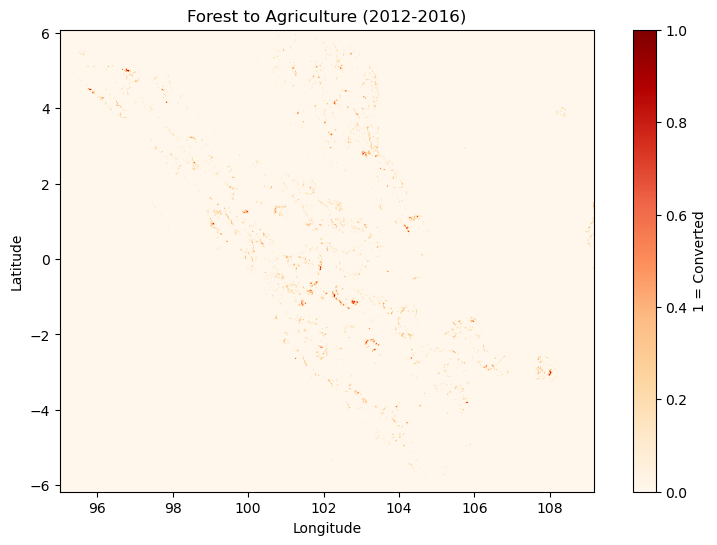

Forest to Agriculture: 73449 pixels
Forest to Urban: 270 pixels
    Class  Count_2012  Count_2016  Change (%)
0     130          50         303  506.000000
1     100          62         172  177.419355
2     110          93         252  170.967742
3      80          14          20   42.857143
4     150       22165       28060   26.595985
5     190       63523       74790   17.736883
6      20        4360        4780    9.633028
7      11      298603      305055    2.160728
8      12      221450      225512    1.834274
9      40     1294870     1316026    1.633832
10    170      140502      141930    1.016356
11     30     1368495     1377468    0.655684
12    120           5           5    0.000000
13    210    16087709    16083725   -0.024764
14     10      226929      224961   -0.867232
15     50     2421883     2383295   -1.593306
16    160      317551      301910   -4.925508


In [1]:

# Load Land Cover (2012 & 2016)
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

ds_2012 = Dataset("landcover_2012.nc")
ds_2016 = Dataset("landcover_2016.nc")

# Extract
lc_2012_arr = ds_2012.variables["lccs_class"][0, :, :]
lc_2016_arr = ds_2016.variables["lccs_class"][0, :, :]
lat = ds_2012.variables["lat"][:]
lon = ds_2012.variables["lon"][:]


#Define 
ipcc_map = {
    10: "Agriculture", 11: "Agriculture", 12: "Agriculture", 20: "Agriculture", 30: "Agriculture", 40: "Agriculture",
    50: "Forest", 60: "Forest", 61: "Forest", 62: "Forest", 70: "Forest", 71: "Forest", 72: "Forest",
    80: "Forest", 81: "Forest", 82: "Forest", 90: "Forest", 100: "Forest", 160: "Forest", 170: "Forest",
    110: "Grassland", 130: "Grassland",
    180: "Wetland", 190: "Settlement",
    120: "Shrubland", 121: "Shrubland", 122: "Shrubland",
    140: "Sparse Vegetation", 150: "Sparse Vegetation", 151: "Sparse Vegetation", 152: "Sparse Vegetation", 153: "Sparse Vegetation",
    200: "Bare Area", 201: "Bare Area", 202: "Bare Area",
    210: "Water"
}

# Vectorize reclassification
ipcc_2012 = np.vectorize(ipcc_map.get)(lc_2012_arr)
ipcc_2016 = np.vectorize(ipcc_map.get)(lc_2016_arr)

# Change Detection, Forest to Agriculture / Urban
forest_class = 50
agriculture_classes = [10, 11, 12, 20, 30,40]
urban_class = 190  # based on IPCC guide

# comparison on original CCI classes
forest_to_agri = ((lc_2012_arr == 50) & np.isin(lc_2016_arr, agriculture_classes))
forest_to_urban = ((lc_2012_arr == 50) & (lc_2016_arr == 190))

# Plot, Forest to Agriculture
plt.figure(figsize=(10, 6))
plt.imshow(forest_to_agri, cmap="OrRd", extent=[lon.min(), lon.max(), lat.min(), lat.max()])
plt.title("Forest to Agriculture (2012-2016)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="1 = Converted")
plt.show()

# Print, Forest to Agriculture / Urban
print("Forest to Agriculture:", int(np.sum(forest_to_agri)), "pixels")
print("Forest to Urban:", int(np.sum(forest_to_urban)), "pixels")


#Class Distribution and Change Summary
def get_counts(arr):
    values, counts = np.unique(arr, return_counts=True)
    return pd.DataFrame({"Class": values, "Count": counts})

df_2012 = get_counts(lc_2012_arr)
df_2016 = get_counts(lc_2016_arr)

df = pd.merge(df_2012, df_2016, on="Class", how="outer", suffixes=("_2012", "_2016")).fillna(0)
df["Change (%)"] = ((df["Count_2016"] - df["Count_2012"]) / df["Count_2012"].replace(0, np.nan)) * 100
df = df.sort_values("Change (%)", ascending=False).reset_index(drop=True)
print(df)


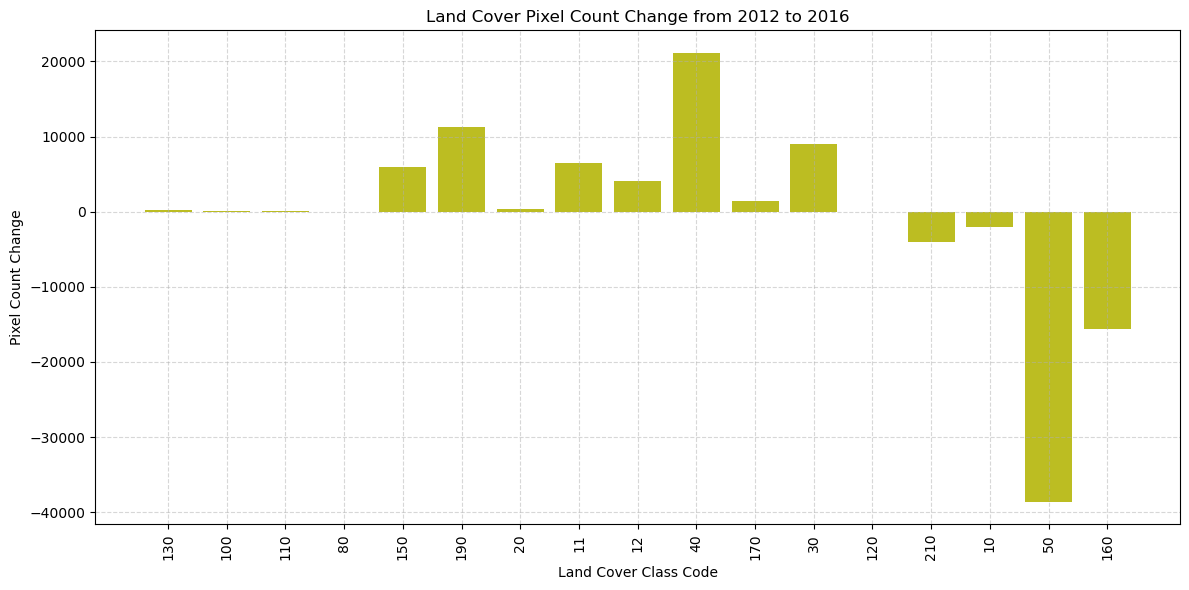

In [2]:
# Plot, Bar chart of class changes 
plt.figure(figsize=(12, 6))
plt.bar(df["Class"].astype(str), df["Count_2016"] - df["Count_2012"], color="#bcbd22")
plt.xticks(rotation=90)
plt.title("Land Cover Pixel Count Change from 2012 to 2016")
plt.xlabel("Land Cover Class Code")
plt.ylabel("Pixel Count Change")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



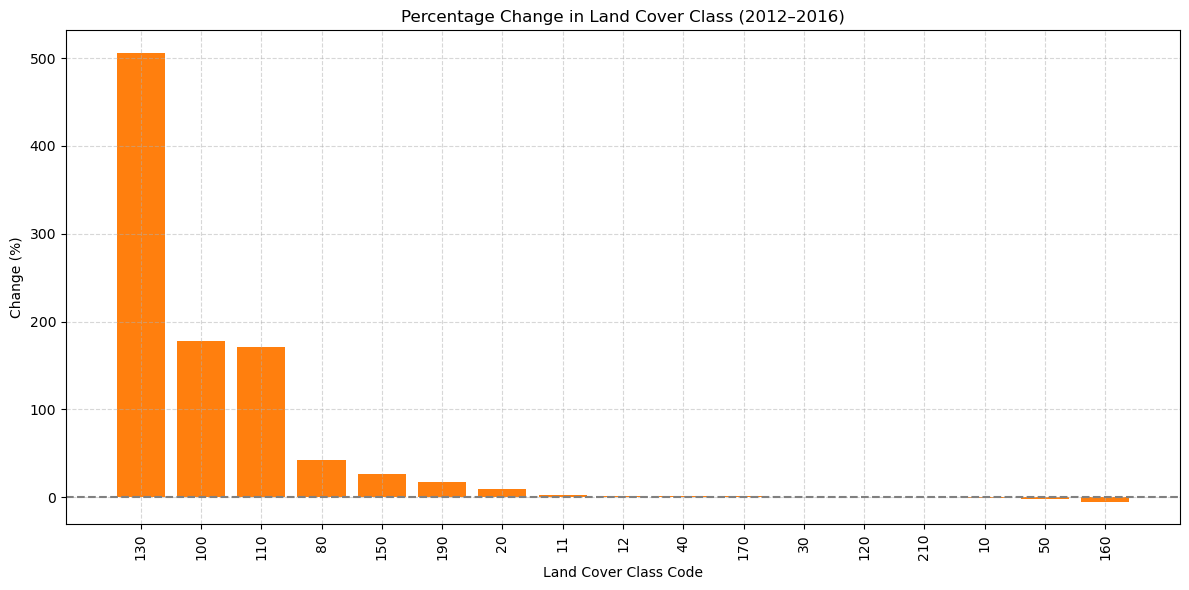

In [3]:
# Plot, Bar chart of percentage change 
plt.figure(figsize=(12, 6))
plt.bar(df["Class"].astype(str), df["Change (%)"], color="#ff7f0e")
plt.xticks(rotation=90)
plt.title("Percentage Change in Land Cover Class (2012–2016)")
plt.xlabel("Land Cover Class Code")
plt.ylabel("Change (%)")
plt.axhline(0, color="gray", linestyle="--")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


          IPCC Class  Count_2012  Count_2016  Change (%)
0        Agriculture     3414707     3453802    1.144901
1             Forest     2880012     2827327   -1.829333
2          Grassland         143         555  288.111888
3         Settlement       63523       74790   17.736883
4          Shrubland           5           5    0.000000
5  Sparse Vegetation       22165       28060   26.595985
6              Water    16087709    16083725   -0.024764


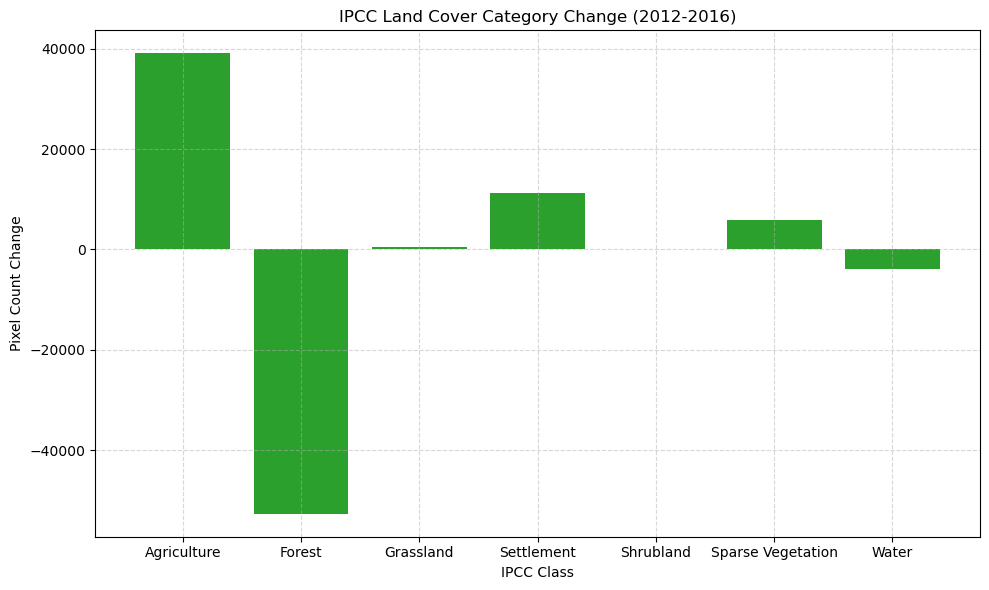

In [4]:
def ipcc_counts(arr):
    flat = arr.flatten()
    df = pd.Series(flat).value_counts().reset_index()
    df.columns = ["IPCC Class", "Count"]
    return df

df_ipcc_2012 = ipcc_counts(ipcc_2012)
df_ipcc_2016 = ipcc_counts(ipcc_2016)

df_ipcc = pd.merge(df_ipcc_2012, df_ipcc_2016, on="IPCC Class", how="outer", suffixes=("_2012", "_2016")).fillna(0)
df_ipcc["Change (%)"] = ((df_ipcc["Count_2016"] - df_ipcc["Count_2012"]) / df_ipcc["Count_2012"].replace(0, np.nan)) * 100
print(df_ipcc)

# Plot, Bar chart for IPCC class change
plt.figure(figsize=(10, 6))
plt.bar(df_ipcc["IPCC Class"], df_ipcc["Count_2016"] - df_ipcc["Count_2012"], color="#2ca02c")
plt.title("IPCC Land Cover Category Change (2012-2016)")
plt.xlabel("IPCC Class")
plt.ylabel("Pixel Count Change")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
fire_gdf = gpd.read_file("fire_archive_SV-C2_582113.shp")
print(fire_gdf.head())


 Number of fire points inside urban expansion areas: 24226
      LATITUDE  LONGITUDE   ACQ_DATE   FRP
798    0.68131  101.11628 2012-02-06  0.72
812    0.68341  101.11597 2012-02-06  1.02
1034   3.62410   98.63062 2012-02-07  2.93
1388   0.68075  101.11930 2012-02-08  0.94
1589   1.67155  101.47511 2012-02-09  2.68


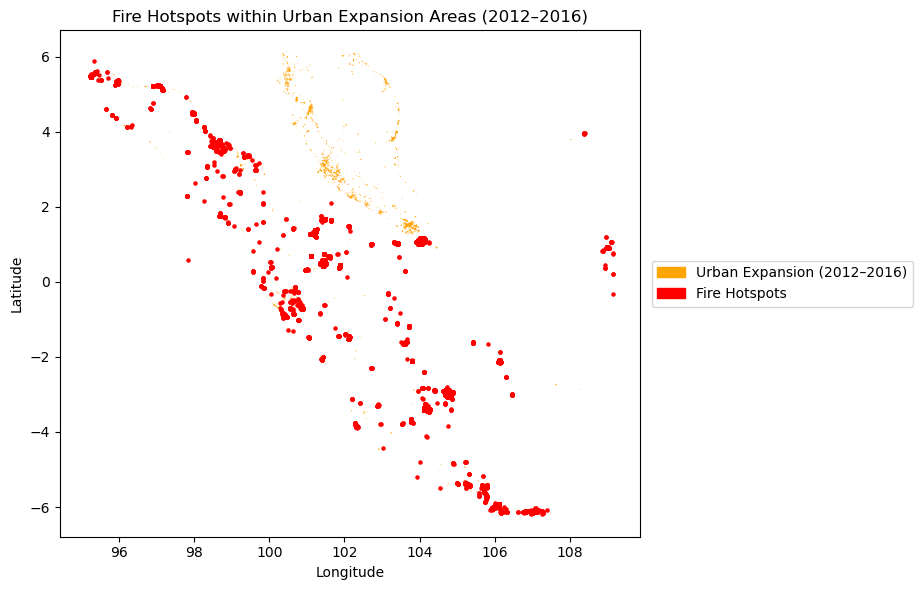

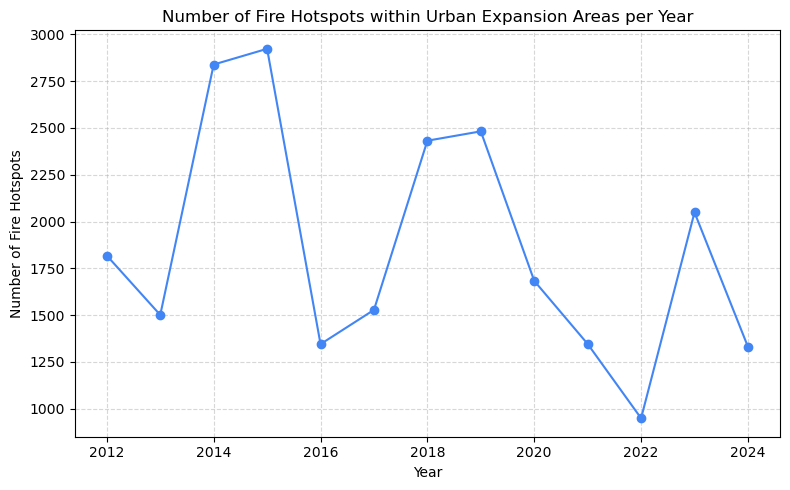

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

urban_expansion_mask = (ipcc_2012 != "Settlement") & (ipcc_2016 == "Settlement")

# coordinates of urban expansion pixels
exp_y, exp_x = np.where(urban_expansion_mask)
exp_coords = [Point(lon[x], lat[y]) for y, x in zip(exp_y, exp_x)]

# GeoDataFrame with WGS84 (EPSG:4326)
urban_expansion_gdf = gpd.GeoDataFrame(geometry=exp_coords, crs="EPSG:4326")
urban_expansion_proj = urban_expansion_gdf.to_crs(epsg=3857)

# buffer in meters 
urban_expansion_buffer = urban_expansion_proj.buffer(1000)
# Convert buffered geometries back to EPSG:4326 
urban_expansion_poly_gdf = gpd.GeoDataFrame(geometry=urban_expansion_buffer, crs="EPSG:3857").to_crs(epsg=4326)


# Load VIIRS fire hotspots
fire_gdf = gpd.read_file("fire_archive_SV-C2_582113.shp")

# fire points that intersect urban expansion areas
fire_in_expansion = gpd.sjoin(fire_gdf, urban_expansion_poly_gdf, how="inner", predicate="intersects")

# Print, summary       FRP = Fire Radiative Power, unit MW
print(f" Number of fire points inside urban expansion areas: {len(fire_in_expansion)}")
print(fire_in_expansion[["LATITUDE", "LONGITUDE", "ACQ_DATE", "FRP"]].head())


fig, ax = plt.subplots(figsize=(10, 6))

# urban expansion 
urban_expansion_poly_gdf.plot(ax=ax, color="orange", alpha=0.5, edgecolor="none")
# fire points
fire_in_expansion.plot(ax=ax, color="red", markersize=5)

#Plot, Fire Hotspots within Urban Expansion Areas
plt.title("Fire Hotspots within Urban Expansion Areas (2012–2016)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
orange_patch = mpatches.Patch(color='orange', label='Urban Expansion (2012–2016)')
red_patch = mpatches.Patch(color='red', label='Fire Hotspots')
plt.legend(handles=[orange_patch, red_patch], loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
plt.tight_layout()
plt.show()


# onvert ACQ_DATE to datetime and extract year
fire_in_expansion["ACQ_DATE"] = pd.to_datetime(fire_in_expansion["ACQ_DATE"])
fire_in_expansion["YEAR"] = fire_in_expansion["ACQ_DATE"].dt.year

# fire points per year
yearly_counts = fire_in_expansion.groupby("YEAR").size().reset_index(name="Fire Count")

# Plot, line chart
plt.figure(figsize=(8, 5))
plt.plot(yearly_counts["YEAR"], yearly_counts["Fire Count"], marker="o", color="#4285F4")
plt.title("Number of Fire Hotspots within Urban Expansion Areas per Year")
plt.xlabel("Year")
plt.ylabel("Number of Fire Hotspots")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
